# Probabilistic forecasting with Random Forests
[Dataset](https://www.kaggle.com/datasets/bulentsiyah/for-simple-exercises-time-series-forecasting')

In [652]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [653]:
df = pd.read_csv("Alcohol_Sales.csv")
df.columns = ["date", "sales"]
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

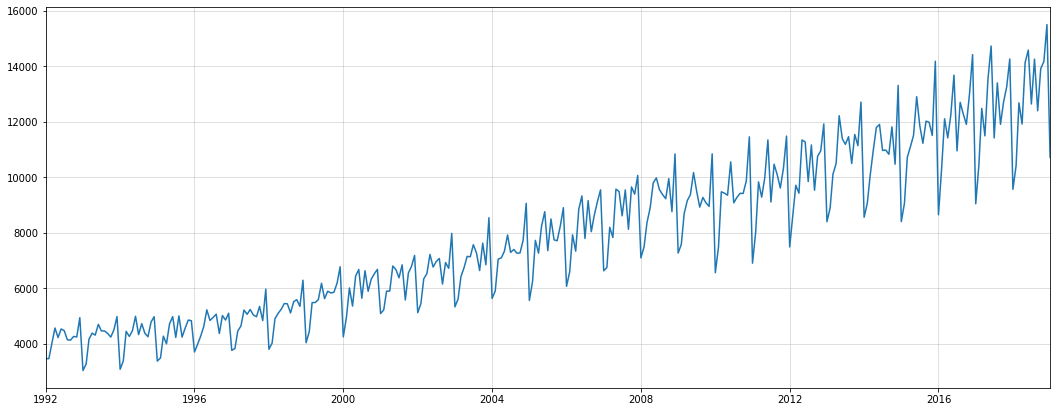

In [1176]:
plt.figure(figsize = (18,7))
plt.plot(df)
plt.grid(alpha=0.5)
plt.margins(x=0)

In [1104]:
df_train = df.iloc[:-36]
df_test = df.iloc[-36:]

## Make time-series stationary
- shift from positive only to all reals via log
- remove trend via first-order differencing
- remove yearly seasonlity via 12th-order differencing

In [1105]:
df_train_logged = np.log(df_train)
df_train_diffed = df_train_logged.diff().dropna()
df_train_trans = df_train_diffed.diff(12).dropna()

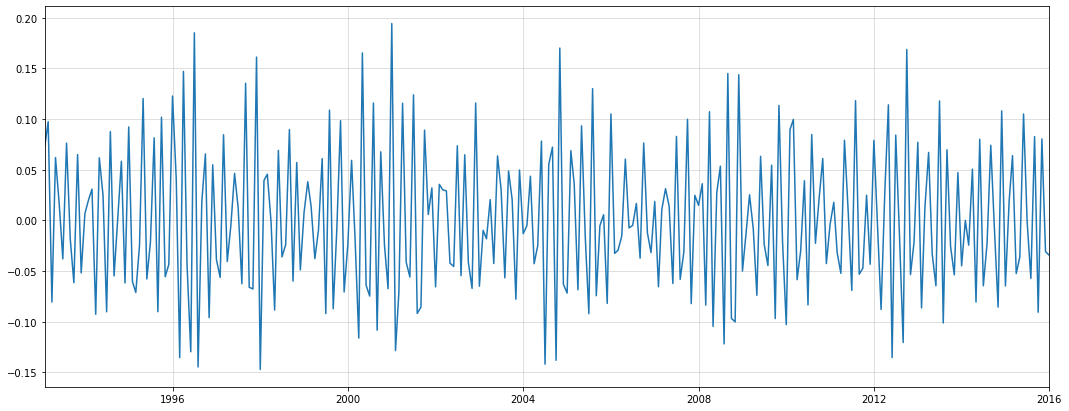

In [1177]:
plt.figure(figsize = (18,7))
plt.plot(df_train_trans)
plt.grid(alpha=0.5)
plt.margins(x=0)

## Fit Random Forest model and perform forecast

In [1166]:
model = RandomForestRegressor(max_depth = 3, n_estimators=1000, random_state = 321)

shift = 72

Xtrain = pd.concat([df_train_trans.shift(t) for t in range(1,shift)],1).dropna()
ytrain = df_train_trans.loc[Xtrain.index,:]

model.fit(Xtrain.values,ytrain)


samples = []

np.random.seed(123)
for i in range(10000):
    Xf = np.concatenate([Xtrain.iloc[-1,1:].values.reshape(1,-1),ytrain.iloc[-1].values.reshape(1,1)],1)

    forecasts = []

    for t in range(len(df_test)):
        tree = model.estimators_[np.random.randint(len(model.estimators_))]
        pred = tree.predict(Xf)[0]
        forecasts.append(pred)

        Xf = np.concatenate([Xf[:,1:],np.array([[pred]])],1)
        
    samples.append(forecasts)


full_sample_tree = []

for samp in samples:
    draw = np.array(samp)
    result = list(df_train_diffed.iloc[-12:].values)

    for t in range(len(df_test)):
        result.append(result[t]+draw[t])

    full_sample_tree.append(np.exp(np.array((np.log(df_train.values[-1])+np.cumsum(result[12:]))).reshape(-1,1)))

/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_34612/2732415570.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  Xtrain = pd.concat([df_train_trans.shift(t) for t in range(1,shift)],1).dropna()
/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_34612/2732415570.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(Xtrain.values,ytrain)


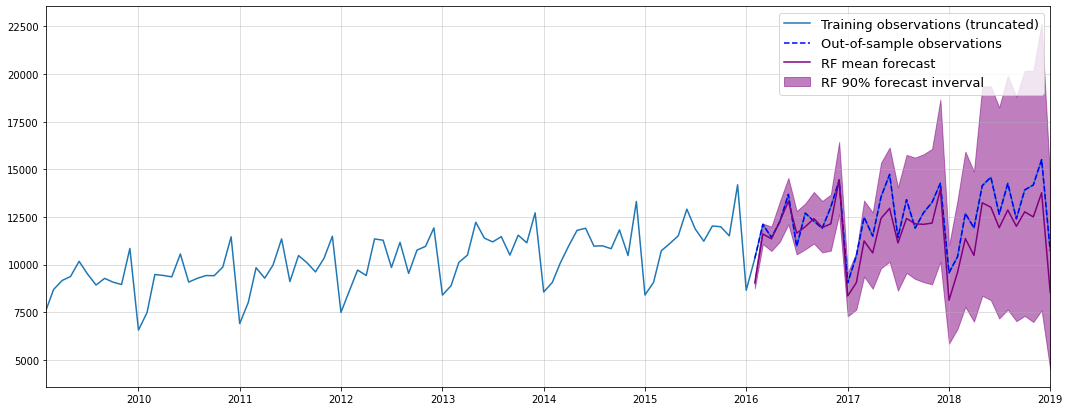

In [1198]:
predictions_tree = np.concatenate(full_sample_tree,1)
means_tree = np.mean(predictions_tree,1)
lowers_tree = np.quantile(predictions_tree,0.05,1)
uppers_tree = np.quantile(predictions_tree,0.95,1)

plt.figure(figsize = (18,7))

plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label = "Training observations (truncated)")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")

plt.plot(df_test.index,means_tree,color="purple", label = "RF mean forecast")

plt.fill_between(df_test.index, lowers_tree, uppers_tree, color="purple", alpha=0.5, label = "RF 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

## Benchmark fitting a kernel density model to the differenced time-series
=> assumes that all autocorrelation has been removed via differencing  
=> see also [here](https://www.sarem-seitz.com/facebook-prophet-covid-and-why-i-dont-trust-the-prophet/#:~:text=An-,even,-simpler%20forecast%20model)

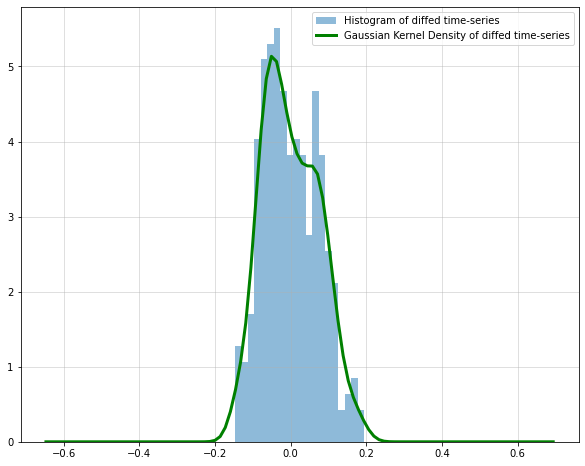

In [1168]:
from scipy.stats import gaussian_kde

plt.figure(figsize = (10,8))
plt.grid(alpha = 0.5)
plt.hist(df_train_trans,bins=20,density = True,alpha=0.5, label = "Histogram of diffed time-series")

kde = gaussian_kde(df_train_trans.values[:,0])

target_range = np.linspace(np.min(df_train_trans.values[:,0])-0.5,np.max(df_train_trans.values[:,0])+0.5,num=100)

plt.plot(target_range, kde.pdf(target_range),color="green",lw=3, label = "Gaussian Kernel Density of diffed time-series")

plt.legend()

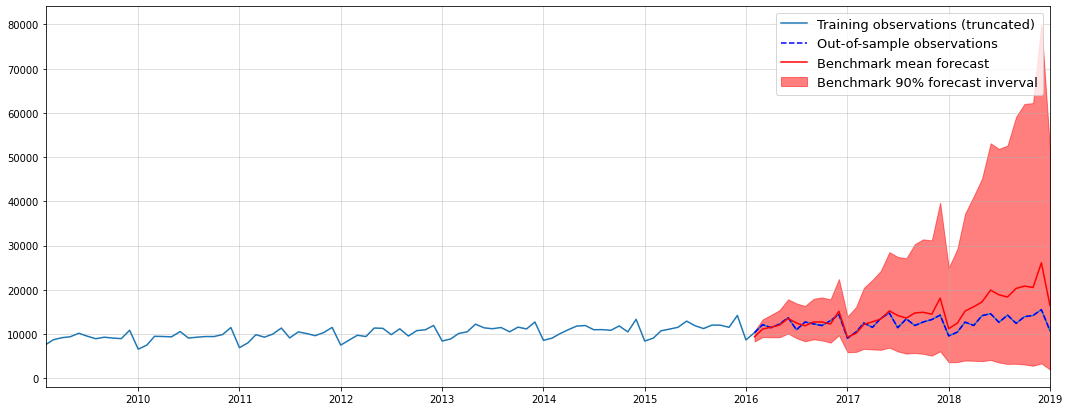

In [1200]:
np.random.seed(321)

full_sample_toy = [] 
np.random.seed(123)
for i in range(10000):
    draw = kde.resample(len(df_test)).reshape(-1)
    result = list(df_train_diffed.iloc[-12:].values)

    for t in range(len(df_test)):
        result.append(result[t]+draw[t])

    full_sample_toy.append(np.exp(np.array((np.log(df_train.values[-1])+np.cumsum(result[12:]))).reshape(-1,1)))

    
predictions_toy = np.concatenate(full_sample_toy,1)
means_toy = np.mean(predictions_toy,1)
lowers_toy = np.quantile(predictions_toy,0.05,1)
uppers_toy = np.quantile(predictions_toy,0.95,1)

plt.figure(figsize = (18,7))

plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label = "Training observations (truncated)")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")

plt.plot(df_test.index,means_toy,color="red", label = "Benchmark mean forecast")

plt.fill_between(df_test.index, lowers_toy, uppers_toy, color="red", alpha=0.5, label = "Benchmark 90% forecast inverval")

plt.legend(fontsize=13)
plt.margins(x=0)

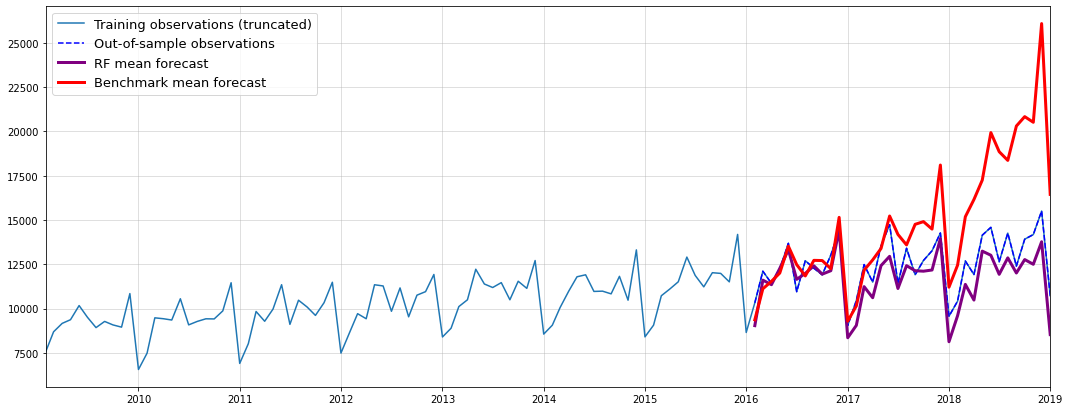

In [1204]:
plt.figure(figsize = (18,7))

plt.grid(alpha=0.5)

plt.plot(df.iloc[-120:], label = "Training observations (truncated)")
plt.plot(df_test, color = "blue", label = "Out-of-sample observations", ls="dashed")

plt.plot(df_test.index,means_tree,color="purple", label = "RF mean forecast",lw = 3)
plt.plot(df_test.index,means_toy,color="red", label = "Benchmark mean forecast", lw = 3)


plt.legend(fontsize=13)
plt.margins(x=0)

## RMSE evaluation Random Forest VS. Benchmark

In [1206]:
np.sqrt(np.mean((df_test.values[:,0] - means_tree)**2))

1056.7707939891948

In [1207]:
np.sqrt(np.mean((df_test.values[:,0] - means_toy)**2))

3597.3603784382817